In [55]:
import sys, os, pathlib
#setting the path to folder with modules
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))
from Load_Datasets import *

In [56]:
FileAddress_movies ="../../Datasets/tmdb_5000_movies.csv"
FileAddress_credits="../../Datasets/tmdb_5000_credits.csv"

In [57]:
#Loading information about movies
Movies,Credentials  = Load_Datasets(FileAddress_movies,FileAddress_credits)

Drops = ['homepage','status','id']
for drop in Drops:
    Movies = Movies.drop(drop, 1)
        
Movies.to_csv("../../Datasets/Transformed.csv")
#print(Movies.dtypes)
#read arrays from string using string.split(",")

In [58]:
Movies['genres_id'] = Movies.apply(lambda row: [int(s) for s in row['genres_id'].split(',') if s.isdigit()], axis=1)

In [59]:
unique_genre = list(set().union(*list(Movies['genres_id'])))

In [60]:
from collections import Counter
#Occurence of genres
Counter([item for sublist in list(Movies['genres_id']) for item in sublist])

Counter({12: 792,
         14: 425,
         16: 234,
         18: 2300,
         27: 520,
         28: 1156,
         35: 1723,
         36: 197,
         37: 82,
         53: 1275,
         80: 697,
         99: 110,
         878: 538,
         9648: 348,
         10402: 185,
         10749: 895,
         10751: 514,
         10752: 144,
         10769: 34,
         10770: 8})

In [61]:
def create_genre_feature(list_genres_id):
    genres_feature = [ int(g in list_genres_id) for g in unique_genre]
    return genres_feature
Movies['genres_feature'] = Movies.apply(lambda row: create_genre_feature(row['genres_id']), axis=1)

In [62]:
Movies['genres_feature'].head()

title
#Horror                       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, ...
(500) Days of Summer          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
10 Cloverfield Lane           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...
10 Days in a Madhouse         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
10 Things I Hate About You    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
Name: genres_feature, dtype: object

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

genres_feature_sparse = sparse.csr_matrix(list(Movies['genres_feature']))

similarities = cosine_similarity(genres_feature_sparse)
distances  = 1 - similarities

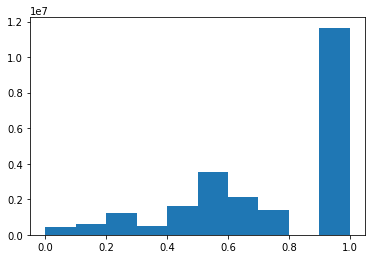

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(distances.reshape(-1), bins=10);

In [65]:
kernel_width = distances.mean()
weights = np.exp(-np.power(distances/kernel_width,2))# Your code here.
np.fill_diagonal(weights, 0)

NEIGHBORS = 10
index_sorted = weights.argsort()
for i in range(0,len(weights)):
    weights[i,index_sorted[i,:-NEIGHBORS]] = 0
different = weights != weights.transpose()
equal = weights == weights.transpose()
weights = weights*equal + weights*different + different*weights.transpose()

In [66]:
weights[0].nonzero()

(array([ 185,  277,  580, 1473, 2404, 3609, 3635, 4069, 4212, 4663]),)

In [67]:
Movies.iloc[0]['genres']

'Drama,Mystery,Horror,Thriller'

In [68]:
Movies.iloc[277]['genres']

'Thriller,Mystery,Drama,Horror'

My network has 4497 nodes.
My network has 32205 edges.
Number of component is 353.
Size of the giant component is 372.
Average clustering 0.6504679122927515.


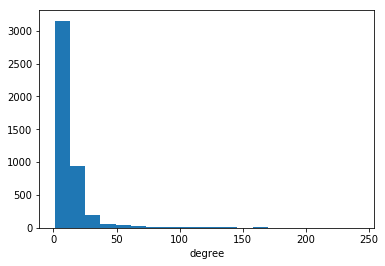

In [127]:
import networkx as nx

rows, cols = np.where(weights == 1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges)

print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

component_G = sorted(nx.connected_components(G), key=len, reverse=True)
print('Number of component is {}.'.format(len(component_G)))

giant_G = max(nx.connected_component_subgraphs(G), key=len)
print('Size of the giant component is {}.'.format(len(giant_G.nodes())))

print('Average clustering {}.'.format(nx.average_clustering(G)))
degree_distribution=sorted(nx.degree(G).values(),reverse=True) # degree distribution sorted from highest to lowest
plt.xlabel('degree')
plt.hist(degree_distribution, bins=20);

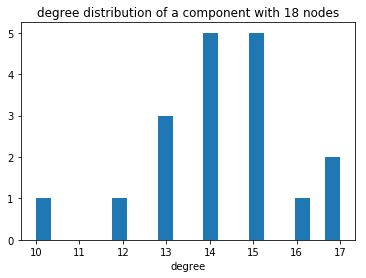

In [160]:
import warnings
warnings.filterwarnings("ignore")

comp=list(component_G[50])
rows, cols = np.where(weights[comp,:][:,comp] == 1)
edges = zip(rows.tolist(), cols.tolist())
sub_G = nx.Graph()
sub_G.add_edges_from(edges)

degree_distribution=sorted(nx.degree(sub_G).values(),reverse=True) # degree distribution sorted from highest to lowest
plt.title('degree distribution of a component with '+str(len(sub_G.nodes()))+' nodes')
plt.xlabel('degree')
plt.hist(degree_distribution, bins=20);

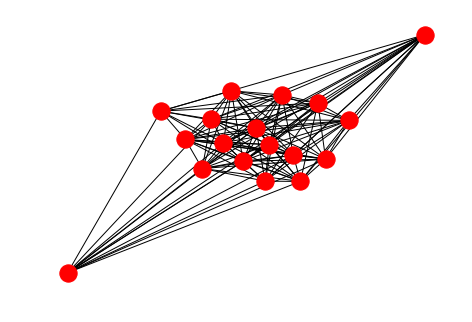

In [161]:
nx.draw(sub_G)